In [1]:
using StatsBase, Distributions, JLD2, PyPlot
include("mbsampler.jl") 

gsample (generic function with 4 methods)

In [16]:
using PyPlot, TimeIt, Distributions, Optim
import PyPlot
const plt = PyPlot
include("ZZ_subsampling.jl")
include("ZZ_clustering.jl") 

ZZ_clustering (generic function with 6 methods)

In [17]:
function logistic_data(d, Nobs, β_true, px, py=0.1) 
    X = ones(d, Nobs)
    X[2:end,:] = rand(Normal(), d-1, Nobs).*rand(Binomial(1,px), d-1, Nobs) 
    #y = [rand(Binomial(1,1./(1+exp.(-X[:,j]'β_true))), 1)[1] for j in 1:Nobs]
    y = rand(Binomial(1,py), Nobs)
    return X, y
end

logistic_data (generic function with 2 methods)

In [18]:
d = 3
Nobs = 10^4
px = 5e-1
py = 5e-1
β_true = rand(d)
X, y = logistic_data(d, Nobs, β_true, px, py)
σ = 2
A = eye(d)
# root = find_root(X, y, σ)
sum(y)

5040

In [19]:
root = find_root(X, y, σ)

3-element Array{Float64,1}:
  0.0154931
 -0.0104615
  0.0517055

In [105]:
function get_clustering(gradient_root, N_cluster, mode, i)
    d, Nobs = size(gradient)
    p = sortperm(gradient_root[i,:])
    vector = gradient_root[i,p]
    split_table = greedy_split_cluster(vector, N_cluster, mode)
    clusters = []
    for c in 1:N_cluster
        clusters =push!(clusters , p[split_table[c,1]:split_table[c,2]])
    end
    return clusters
end
function get_clustering(gradient, N_cluster, mode)
    d, Nobs = size(gradient)
    clusters_all = []
    for i in 1:d
        p = sortperm(gradient_root[i,:])
        vector = gradient_root[i,p]
        split_table = greedy_split_cluster(vector, N_cluster, mode)
        clusters = []
        for c in 1:N_cluster
            clusters =push!(clusters , p[split_table[c,1]:split_table[c,2]])
        end
        clusters_all = push!(clusters_all, clusters)
    end
    return clusters_all
end
function built_cmbsampler(clusters, weights=[], tol_factor=1, grouping=[], scp=-1)
    N_clusters, = size(clusters)
    csamplers = Array{mbsampler}(N_clusters)
    for (ci, c) in enumerate(clusters)
        if weights != [] && max(weigths[c])/mean(weigths[c]) > tol_factor
            csamplers[ci] = wumbsampler(size(c)[1], scp[ci], w[c])
    end
    
end
function built_cmbsampler_list(d, Nobs, clusters_list, weights=[], grouping=[])
    for i in 1:d
        clusters = clusters_list[i]
        csamplers = Array{mbsampler}(2)
        if weights == [] || sum(weights[d,:]) < 0
            for (ci, c) in enumerate(clusters)
                csamplers[ci] = wumbsampler(size(c)[1], scp[ci], w[c])
            end
        end
    end
w = [.1,.1,.2,.2,.05,.1,0.1]
w/=sum(w)
N, = size(w)
x = 1:N

clusters = [[1,2,3,4],[5,6,7]]

scp = [mb_size/2,mb_size/2]

csamplers = Array{mbsampler}(2)
for (ci, c) in enumerate(clusters)
    csamplers[ci] = wumbsampler(size(c)[1], scp[ci], w[c])
end

gw = cmbsampler(csamplers, clusters)


get_clustering (generic function with 1 method)

In [112]:
clusters = [[1,2,3,4],[5,6,7]]
size(clusters)

(2,)

In [43]:
d, n_clusters = size(cluster_sizes)
scp = convert(Array{Int64,1},ones(d))
aclusters_all = []
for i in 1:d
    cindex_left = 1
    aclusters = []
    for ci in 1:n_clusters
        cindices = cindex_left:cluster_sizes[i,ci]
        cindex_left = cindex_left + cluster_sizes[i,ci]
        #print(cindices)
        #print("\n")
        #print(clusters[d,cindices])
        aclusters=push!(aclusters, clusters[i,cindices])
        #scp[i]
        aclusters = convert(Array{Array{Int64,1},1},aclusters)
    end
    push!(aclusters_all, copy(aclusters))
end
#aclusters_all = convert(Array{Array{Int64,1},1},aclusters_all)

groups_all = convert(Array{Int64,1},ones(d))

cmbsamplers = Array{cmbsampler}(d)

for dim in 1:d
    csamplers = Array{mbsampler}(n_clusters)
    for (ci, c) in enumerate(clusters)
        csamplers[ci] = wumbsampler(size(c)[1], scp[ci], w[c])
    end
end

#gw = cmbsampler(csamplers, clusters)
#print(aclusters_all[3])

LoadError: [91mUndefVarError: cluster_sizes not defined[39m

cluster_sizes[i,ci]

In [54]:
d, Nobs = size(X)
gradient_root = zeros(d, Nobs)
for n in 1:Nobs 
    gradient_root[:,n] = [derivative(X[:,n], y[n], k, root, Nobs, σ)[1] for k in 1:d]
end

In [78]:
function comp_score(vector)
    Nit, = size(vector)
    score = zeros(Nit-1)
    for i in 1:(Nit-1)
        fmean1 = mean(vector[1:i])
        fmean2 = mean(vector[(i+1):Nit])
        val1 = sum(abs.(vector[1:i] - fmean1))
        val2 = sum(abs.(vector[(i+1):Nit] - fmean2))
        score[i] = val1 + val2
    end
    return score
end
#plot((i0+1):(i0-1+Nit),score)
function find_split(vector)
    _, imin = findmin(comp_score(vector))
    return imin
end

function find_split(vector, i0)
    fmean = mean(vector)
    current_score = sum(abs.(vector - fmean))
    split_score, split_index = findmin(comp_score(vector))
    return (i0-1)+split_index, split_score, current_score
end

function v2split_cluster(vector, logN_cluster)
    Nit, = size(vector)
    splits = []
    imin = find_split(vector)
    splits = push!(splits, imin)
    if logN_cluster > 1
        splits = push!(splits, v2split_cluster(vector[1:imin], logN_cluster-1)...)
        splits = push!(splits, imin + v2split_cluster(vector[(imin+1):Nit], logN_cluster-1)...)
    end
    return splits
end
function comp_score2(vector)
    Nit, = size(vector)
    score = zeros(Nit-1)
    for i in 1:(Nit-1)
        fmean1 = mean(vector[1:i])
        fmean2 = mean(vector[(i+1):Nit])
        val1 = i*sum(abs.(vector[1:i] - fmean1))
        val2 = (Nit-i)*sum(abs.(vector[(i+1):Nit] - fmean2))
        score[i] = val1 + val2
    end
    return score
end

function comp_score_wc(vector)
    Nit, = size(vector)
    score = zeros(Nit-1)
    for i in 1:(Nit-1)
        val1 = i* (vector[i]- vector[1])
        val2 = (Nit-i)*(vector[Nit]- vector[i+1])
        score[i] = val1 + val2
    end
    return score
end

comp_score_wc (generic function with 1 method)

In [93]:
function comp_minscore_mean_fast(vector)
    Nit, = size(vector)
    score = zeros(2)
    fmean = mean(vector)
    left = 1
    right = Nit
    while true
        Nit2 = right-left
        split_left = Int(left + floor(Nit2/2))
        split_right = split_left+1
        for (ii,iv) in enumerate([split_left,split_right])
            fmean1 = mean(vector[1:iv])
            fmean2 = mean(vector[(iv+1):Nit])
            val1 = sum(abs.(vector[1:iv] - fmean1))
            val2 = sum(abs.(vector[(iv+1):Nit] - fmean2))
            score[ii] = val1 + val2
        end
        if score[1] < score[2]
            right = split_left
        else
            left = split_right
        end
        if left == right
            break
        end
    end
    return min(score...), left
end
function comp_minscore_wc_fast(vector)
    minval, minindex = findmin(comp_score_wc(vector))
    Nit, = size(vector)
    print(Nit)
    #print("Scorediff: ",minval-Nit*(vector[Nit]-vector[1]),"\n")
    return minval, minindex
end

function comp_minscore_fast(vector,mode)
    if mode == "wc"
        split_score, split_index = comp_minscore_wc_fast(vector)
    else
        split_score, split_index = comp_minscore_mean_fast(vector)
    end
    return split_score, split_index
end

function find_split_fast(vector, i0,mode)
    if mode == "wc"
        Nit, = size(vector)
        current_score = Nit*(vector[Nit]-vector[1])
    else
        fmean = mean(vector)
        current_score = sum(abs.(vector - fmean))
    end
    
    split_score, split_index = comp_minscore_fast(vector,mode)
    
    return (i0-1)+split_index, split_score, current_score
end

find_split_fast (generic function with 1 method)

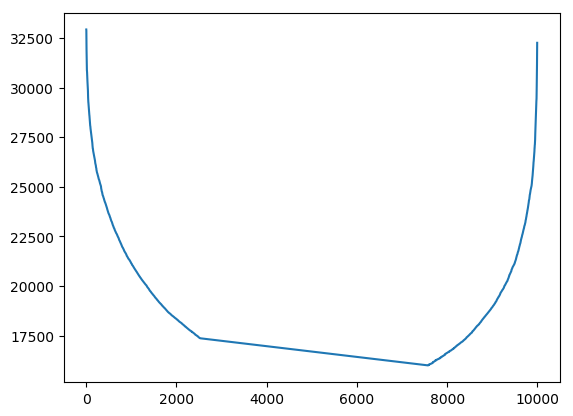

10000(15999.094823451467, 7576)10000504049611649453150189134151531659249281026061418474119234018647410×6 Array{Float64,2}:
    1.0    51.0    186.0   4.22258    -2.41624    2.0
 5041.0  5046.0   5056.0   0.191536   -0.114794   0.0
 5056.0  5331.0   5865.0  20.7313    -11.2501     3.0
 3150.0  4076.0   4567.0  17.1106     -9.27494    4.0
 8470.0  9212.0   9661.0  15.0687     -7.95319    5.0
  659.0  1413.0   3150.0  19.5184    -11.9287     6.0
 5865.0  6703.0   8470.0  18.8749    -10.866      7.0
 4567.0  4901.0   5040.0  14.9785     -8.68074    8.0
 9661.0  9906.0  10000.0   9.76037    -5.71001    9.0
  186.0   386.0    659.0   4.81096    -2.4537    10.010000247175305948158266318091215368500194886494615451066355325611310×6 Array{Float64,2}:
    1.0    50.0    154.0  113.092    -64.5141   2.0
 2472.0  2472.0   7472.0    0.0        0.0      0.0
 8419.0  8760.0   9081.0  132.91     -66.9116   3.0
  663.0  1080.0   1526.0  262.912   -132.151    4.0
 9633.0  9759.0   9888.0   73.9694   -37.

3-element Array{Any,1}:
 Any[[3601, 9136, 8494, 5087, 152, 1108, 788, 7941, 9284, 4400  …  2677, 4289, 6448, 2124, 3678, 2968, 8700, 9727, 1049, 5177], [9137, 41, 8924, 3516, 3488, 8615, 2316, 1953, 9990, 7526, 149, 7936, 7794, 4073, 4440, 2788], [2788, 1122, 1431, 4445, 8544, 6967, 1521, 109, 538, 7034  …  3692, 1111, 942, 6256, 8378, 7283, 2338, 64, 8186, 2082], [9586, 1563, 4503, 2651, 1267, 2792, 9589, 8419, 5683, 6491  …  3292, 1597, 8142, 8471, 6568, 6816, 9677, 4911, 9080, 8012], [220, 448, 7173, 3434, 2396, 2386, 7991, 1786, 6220, 320  …  407, 1141, 1470, 9380, 9193, 1285, 8272, 779, 5370, 8150], [9499, 4236, 8829, 6743, 9901, 5630, 4002, 8299, 3317, 8554  …  9973, 9981, 10000, 8020, 1439, 3125, 6757, 9240, 4564, 9586], [2082, 5210, 2108, 9799, 6046, 627, 4606, 4517, 4465, 9033  …  3689, 4926, 9563, 2135, 3844, 2695, 5469, 9746, 3084, 220], [8012, 7290, 6016, 9386, 1733, 2100, 5183, 6320, 9846, 2883  …  869, 7989, 9002, 3505, 7522, 7975, 3031, 2684, 6360, 7738], [8150, 653, 295

In [107]:
for i in 3
    p = sortperm(gradient_root[i,:])
    vector = gradient_root[i,p]
    score = comp_score_wc(vector)
    plot(score)
    print(comp_minscore_fast(vector,"wc"))
end

clusters = get_clustering(gradient_root, 10, "wc")

In [95]:
print(score[1873],"\n")
print(score[1874])

LoadError: [91mMethodError: no method matching getindex(::StatsBase.#score, ::Int64)[39m

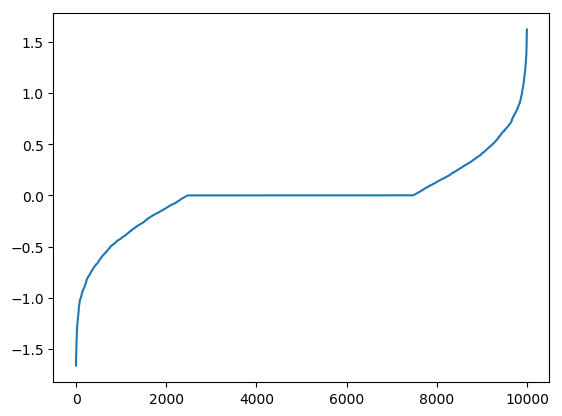

In [96]:
for i in 2
    p = sortperm(gradient_root[i,:])
    vector = gradient_root[i,p]
    plot(vector)
end

In [97]:
function greedy_split_cluster(vector, N_cluster, mode)
    split_table = zeros(N_cluster,6) # 1 range_start | 2 split index | 3 range_end | 4 current_score | 5 delta_score | 6 cluster index 
    temp = zeros(6)
    Nit, = size(vector)
    imin, _, _ = find_split_fast(vector,1,mode)
    #print("imin: ",imin)
    split_index1, split_score1, current_score1 = find_split_fast(vector[1:imin],1,mode)
    split_index2, split_score2, current_score2 = find_split_fast(vector[imin:Nit],imin+1,mode)
    #print("split_index1: ",split_index1)
    #print("split_index2: ",split_index2)
    split_table[1,1] = 1
    split_table[1,2] = split_index1
    split_table[1,3] = imin
    split_table[1,4] = current_score1
    #print(current_score1)
    #print(split_score1)
    split_table[1,5] = split_score1 - current_score1 
    split_table[1,6] = 1
    
    split_table[2,1] = imin + 1
    split_table[2,2] = split_index2
    split_table[2,3] = Nit
    split_table[2,4] = current_score2
    split_table[2,5] = split_score2 - current_score2
    split_table[1,6] = 2
    
    n_cluster = 2
    
    while n_cluster < N_cluster
        
        val, i = findmin(split_table[1:n_cluster,5])
        if (val==Inf)
            print("All scores are infinite")
            print(split_table[1:n_cluster,:])
            print("blabla")
        end
        temp[1] = split_table[i,1]
        temp[3] = split_table[i,2]
        #print("split_table_temp",split_table[:,5])
        
        if split_table[i,1] == split_table[i,2]
            temp[2] = NaN
            temp[5] = Inf
        else
            #print(temp)
            split_index_temp, split_score_temp, current_score_temp = find_split_fast(vector[Int(temp[1]):Int(temp[3])],Int(temp[1]),mode)
            temp[2] = split_index_temp
            temp[5] = split_score_temp - current_score_temp
        end 
        temp[4] = current_score_temp
        temp[6] = split_table[i,6]
        
        
        split_table[n_cluster+1,1] = split_table[i,2]
        split_table[n_cluster+1,3] = split_table[i,3] 
        if (split_table[i,2]) == split_table[i,3]
            split_table[n_cluster+1,2] = NaN
            split_table[n_cluster+1,5] = Inf
        else
            split_index_temp, split_score_temp, current_score_temp = find_split_fast(vector[Int(split_table[n_cluster+1,1]):Int(split_table[n_cluster+1,3])],
                                                                            Int(split_table[n_cluster+1,1]),mode)
            split_table[n_cluster+1,2] = split_index_temp
            split_table[n_cluster+1,5] =  split_score_temp - current_score_temp
        end    
        split_table[n_cluster+1,4] = current_score_temp
        split_table[n_cluster+1,6] = n_cluster+1
        
        
        split_table[i,:] = copy(temp)
        n_cluster = n_cluster + 1
        
    end
    #print("Split table:", split_table,"\n")
    Base.showarray(STDOUT,split_table,false)
    return convert(Array{Int64,2},split_table[:,[1,3]])
end

greedy_split_cluster (generic function with 1 method)

100002471

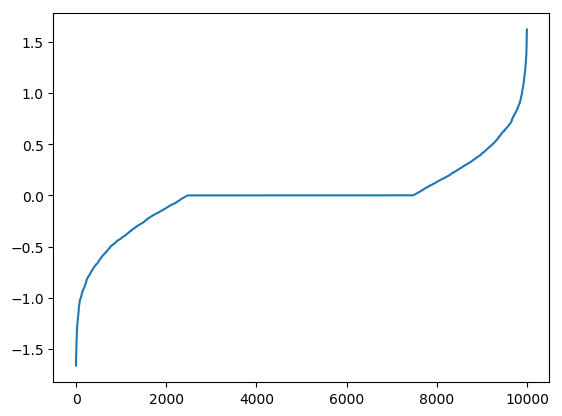

7530594815826631809121536850019488649461545108×6 Array{Float64,2}:
    1.0    50.0    154.0  113.092   -64.5141  2.0
 2472.0  2472.0   7472.0    0.0       0.0     0.0
 8419.0  9081.0   9633.0  567.735  -288.112   3.0
  663.0  1080.0   1526.0  262.912  -132.151   4.0
 9633.0  9888.0  10000.0  338.101  -194.604   5.0
 7472.0  7937.0   8419.0  223.908  -112.602   6.0
 1526.0  1984.0   2471.0  238.335  -119.623   7.0
  154.0   384.0    663.0  189.618   -96.9115  8.0Split table2:[1 154; 2472 7472; 8419 9633; 663 1526; 9633 10000; 7472 8419; 1526 2471; 154 663]


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1362071d0>

In [113]:
N_clusters=8
dd=2
p = sortperm(gradient_root[dd,:])
split_table2 = greedy_split_cluster(gradient_root[dd,p], N_clusters,"wc")
print("Split table2:", split_table2,"\n")

#clusters = []
#for i in 1:N_clusters
#    clusters=push!(clusters, p[split_table2[i,1]:split_table2[i,2]])
#end
#clusters = convert(Array{Array{Int64,1},1},clusters)

#for i in 1:N_clusters
#    vector = gradient_root[dd,split_table[i,1]:split_table[i,2]]
#    #print(vector)
#    #print("\n")
#    PyPlot.plt[:hist](vector,bins=100);
#end
#print(clusters)
plot(gradient_root[dd,p])
#for i in 1:N_clusters
#    plot(split_table2[i,1],gradient_root[dd,split_table2[i,1]])
#end

In [102]:
size(split_table2)

(8, 2)

In [103]:
split_table2[1:1,1]

1-element Array{Int64,1}:
 1

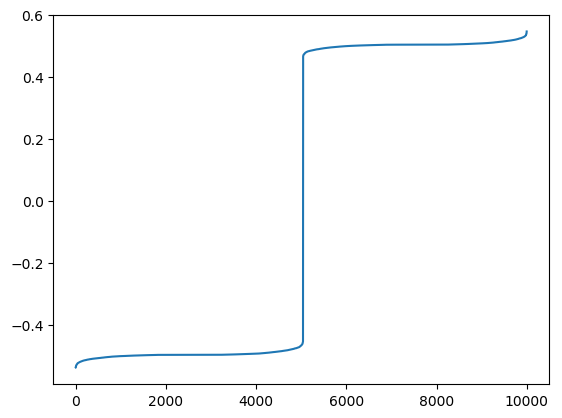

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1223e1710>

In [104]:
#plot(sort(gradient_root[1,:]))
p = sortperm(gradient_root[1,:])
plot(gradient_root[1,p])

In [32]:
comp_score(gradient_root[1,p])

9999-element Array{Float64,1}:
 4997.41
 4996.88
 4996.35
 4995.82
 4995.3 
 4994.77
 4994.24
 4993.72
 4993.2 
 4992.67
 4992.15
 4991.62
 4991.1 
    ⋮   
 4991.44
 4991.98
 4992.52
 4993.06
 4993.6 
 4994.14
 4994.68
 4995.22
 4995.76
 4996.3 
 4996.85
 4997.4 

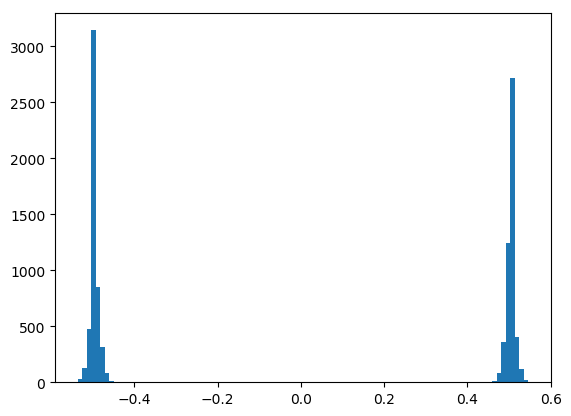

In [33]:
PyPlot.plt[:hist](gradient_root[1,:],bins=100);